# Stationary analysis of noise from linescan confocal microscopy
Aims:

1. Open an oib file (x,t,c) which contains fluorescence time series with putative single channel activity. 

2. Convert to Ome-Zarr format.

3. Filter and visualize data.

4. Perform stationary noise analysis before and after stimulation.


## Install required libraries

In [1]:
print("Installing necessary libraries...")
!pip install oiffile ome-zarr > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load libraries

In [2]:
import oiffile
import os
import numpy as np
import zarr
from ome_zarr.io import parse_url
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit


## Define File Paths

In [3]:
directory_path = '/home/jovyan/LNMA/guerreroa/data/'
filename = '14-11-24_Exp1_TYH_mib_22C_15segundos.oib'
#filename = '14-11-24_Exp1_TYH_FB_22C.oib'

file_path = os.path.join(directory_path, filename)
oib_file_path = file_path
ome_zarr_path = f'{file_path[:-4]}.zarr'

## Load Image Data and Metadata from OIB

In [4]:
with oiffile.OifFile(oib_file_path) as oib:
    image_data = oib.asarray()  # Load image data
    all_metadata = dict(oib.mainfile)  # Retrieve all metadata as a dictionary

# Display a portion of the metadata for verification
print("Sample Metadata:", {k: all_metadata[k] for k in list(all_metadata)[:5]})

Sample Metadata: {'2D Display': {'Center Point Type': '0', 'ChAutoFit': '1', 'Columns': '2', 'Grid': '0', 'H Axis': 'C', 'Image Size Auto': '1', 'L End Pos': '-1', 'L Interval': '1', 'L Start Pos': '1', 'Rows': '1', 'Show Center Point': '0', 'ShowDivisionsOnScale': 1, 'ShowLabelOnColorBar': 1, 'ShowLabelOnScale': 1, 'T End Pos': '-1', 'T Interval': '1', 'T Start Pos': '1', 'Tile Type': '1', 'V Axis': 'C', 'View 1': '1', 'View 2': '2', 'View Cnt': '2', 'View Max CH': '2', 'Z End Pos': '-1', 'Z Interval': '1', 'Z Start Pos': '1'}, 'Acquisition Parameters Common': {'Acquisition Device': 'FV1000', 'AcquisitionMode': 1, 'Assign Dye Manually': 0, 'Auto C.A': 1, 'Auto HV': 0, 'EveryTrigger Enable': 0, 'FindMode': 1, 'GUI StartScanMode': 1, 'GUI StopScanMode': 1, 'ImageCaputreDate': '2024-11-14 12:24:39', 'ImageCaputreDate+MilliSec': 759, 'IntegrationCount': 0, 'IntegrationType': 'None', 'LaserTransmissivity01': 0.1, 'LaserWavelength01': 488, 'LightPath': 2, 'Number of use Laser': 1, 'Observat

## Format Image Data for OME-Zarr

In [5]:
# Ensure data shape is in (T, C, Z, Y, X) format
while image_data.ndim < 5:
    image_data = np.expand_dims(image_data, axis=0)  # Add dimensions as needed

# Convert the data to a numpy array (if not already)
image_data = np.asarray(image_data)

# Reorder data
image_data = image_data.transpose(0, 2, 1, 3, 4)

## Remove Existing Zarr Store (if exists)

In [6]:
if os.path.exists(ome_zarr_path):
    import shutil
    shutil.rmtree(ome_zarr_path)

## Save Image Data and Metadata to OME-Zarr

In [7]:
store = parse_url(ome_zarr_path, mode="w").store
root = zarr.group(store=store)
dataset = root.create_dataset("image_data", data=image_data, chunks=True)

# Save image metadata and ROI metadata as attributes
root.attrs["image_metadata"] = all_metadata
print("Conversion complete. The OME-Zarr file is saved with all metadata.")

Conversion complete. The OME-Zarr file is saved with all metadata.


## Load and Display Metadata from OME-Zarr

In [8]:
# Load the OME-Zarr file
root = zarr.open(ome_zarr_path, mode="r")

# Display metadata
image_metadata = root.attrs.get("image_metadata", {})

#print("Image Metadata:", image_metadata)

image_date = image_metadata.get('Acquisition Parameters Common', {}).get('ImageCaputreDate', 'Date not found')
print("Image Date:", image_date)

channel_1 = image_metadata.get('Channel 1 Parameters', {}).get('DyeName', 'DyeName not found')
channel_2 = image_metadata.get('Channel 2 Parameters', {}).get('DyeName', 'DyeName not found')

print("Channel 1", channel_1)
print("Channel 2", channel_2)

# Retrieve PhysicalSizeY from Reference Image Parameter
physical_size_y = image_metadata.get('Reference Image Parameter', {}).get('HeightConvertValue', 'PhysicalSizeY not found')
print("Physical Size Y:", physical_size_y)



# Retrieve ScanSpeed, Time Per Frame, Time Per Line, and Time Per Pixel
scan_speed = image_metadata.get('Acquisition Parameters Common', {}).get('SamplingClock', 'ScanSpeed not found')
time_per_frame = image_metadata.get('Axis 4 Parameters Common', {}).get('EndPosition', 'Time Per Frame not found')

pixel_size = image_metadata.get('Reference Image Parameter', {}).get('WidthConvertValue', 'Time Per Pixel not found')
print("Scan Speed:", scan_speed)
print("Time Per Frame:", time_per_frame)
print("Pixel Size:", pixel_size)

Image Date: 2024-11-14 12:24:39
Channel 1 fluo-5N
Channel 2 None
Physical Size Y: 0.033
Scan Speed: 80000
Time Per Frame: 69627.75
Pixel Size: 0.033


In [9]:
## Access and Visualize the Fluo-5N Image in the OME-Zarr File

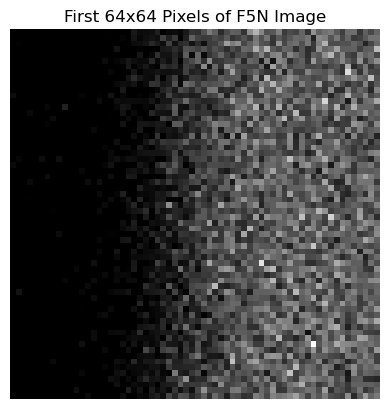

In [10]:
# Access the Fluo - 5N image slice (T=0, C=3, Z=0), adjust as needed based on dimensionality
F5N_image = root["image_data"][0, 0, 0, :, :]  # Assuming (T, C, Z, Y, X) format
# Apply Gaussian blur 
#F5N_image = gaussian_filter(F5N_image, sigma=3)


time_per_line = itime_per_line = time_per_frame/len(F5N_image)
# Slice the first 64x64 pixels
F5N_image_64x64 = F5N_image[:64, :64]

# Display the first 64x64 pixels
plt.imshow(F5N_image_64x64, cmap="gray")
plt.title("First 64x64 Pixels of F5N Image")
plt.axis("off")
plt.show()


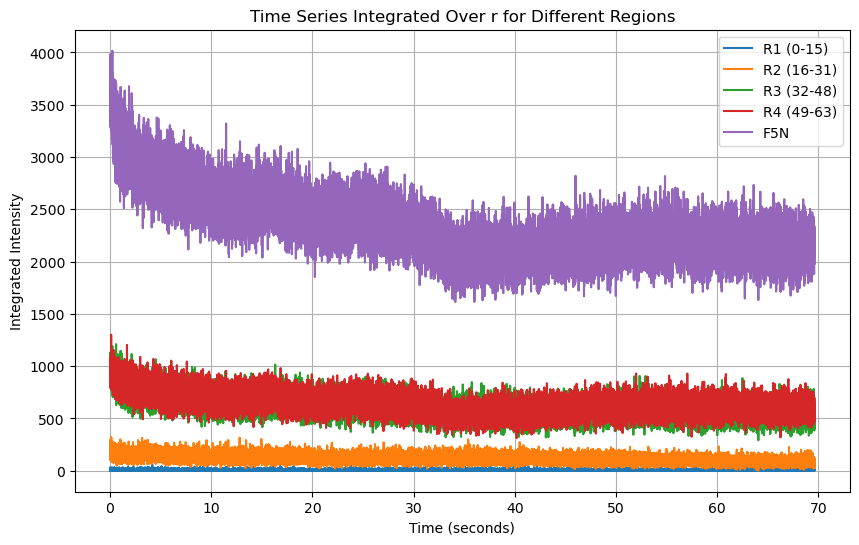

In [11]:

# Convert time to seconds
time_domain = np.arange(len(F5N_image)) * (time_per_line / 1000)  # Time domain in seconds

# Define ranges
R1 = F5N_image[:, 0:15]
R2 = F5N_image[:, 16:31]
R3 = F5N_image[:, 32:48]
R4 = F5N_image[:, 49:63]

# Integrate over r for each region

time_series_R1 = np.trapz(R1, axis=1)
time_series_R2 = np.trapz(R2, axis=1)
time_series_R3 = np.trapz(R3, axis=1)
time_series_R4 = np.trapz(R4, axis=1)
time_series_F5N = np.trapz(F5N_image, axis=1)

# Plot all time series in the same plot with updated time domain
plt.figure(figsize=(10, 6))

plt.plot(time_domain, time_series_R1, label='R1 (0-15)', linewidth=1.5)
plt.plot(time_domain, time_series_R2, label='R2 (16-31)', linewidth=1.5)
plt.plot(time_domain, time_series_R3, label='R3 (32-48)', linewidth=1.5)
plt.plot(time_domain, time_series_R4, label='R4 (49-63)', linewidth=1.5)
plt.plot(time_domain, time_series_F5N, label='F5N', linewidth=1.5)
plt.title("Time Series Integrated Over r for Different Regions")
plt.xlabel("Time (seconds)")
plt.ylabel("Integrated Intensity")
plt.legend()
plt.grid(True)
plt.show()

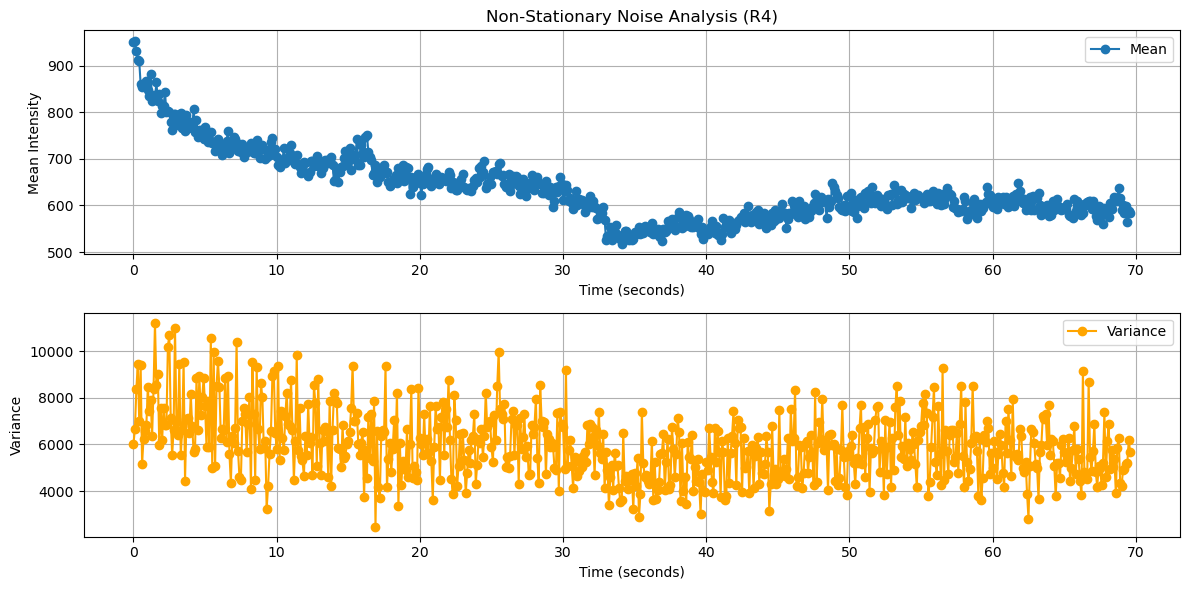

In [12]:

# Parameters for the non-stationary noise analysis
window_duration_ms = 100  # Time window in milliseconds
window_size = int(window_duration_ms / time_per_line)  # Convert to number of samples
num_windows = len(time_series_R4) // window_size

# Initialize lists to store results
mean_values = []
variance_values = []
window_indices = []

# Perform analysis for each window
for i in range(num_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window_data = time_series_R4[start_idx:end_idx]
    
    # Calculate mean and variance for the window
    mean_values.append(np.mean(window_data))
    variance_values.append(np.var(window_data))
    window_indices.append(i * (window_duration_ms / 1000))  # Convert to seconds

# Plot results
plt.figure(figsize=(12, 6))

# Plot mean values
plt.subplot(2, 1, 1)
plt.plot(window_indices, mean_values, label="Mean", marker='o')
plt.title("Non-Stationary Noise Analysis (R4)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.legend()

# Plot variance values
plt.subplot(2, 1, 2)
plt.plot(window_indices, variance_values, label="Variance", marker='o', color='orange')
plt.xlabel("Time (seconds)")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
def non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms):
    """
    Perform non-stationary noise analysis on a time series.

    Parameters:
        time_series (np.array): The time series data to analyze.
        time_per_line (float): Time per line in milliseconds.
        window_duration_ms (float): Duration of the time window in milliseconds.

    Returns:
        tuple: Two lists containing the mean intensities and variances for each time window.
    """
    # Calculate window size in number of samples
    window_size = int(window_duration_ms / time_per_line)
    num_windows = len(time_series) // window_size

    # Initialize lists to store results
    mean_values = []
    variance_values = []

    # Perform analysis for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = time_series[start_idx:end_idx]

        # Calculate mean and variance for the window
        mean_values.append(np.mean(window_data))
        variance_values.append(np.var(window_data))

    return mean_values, variance_values


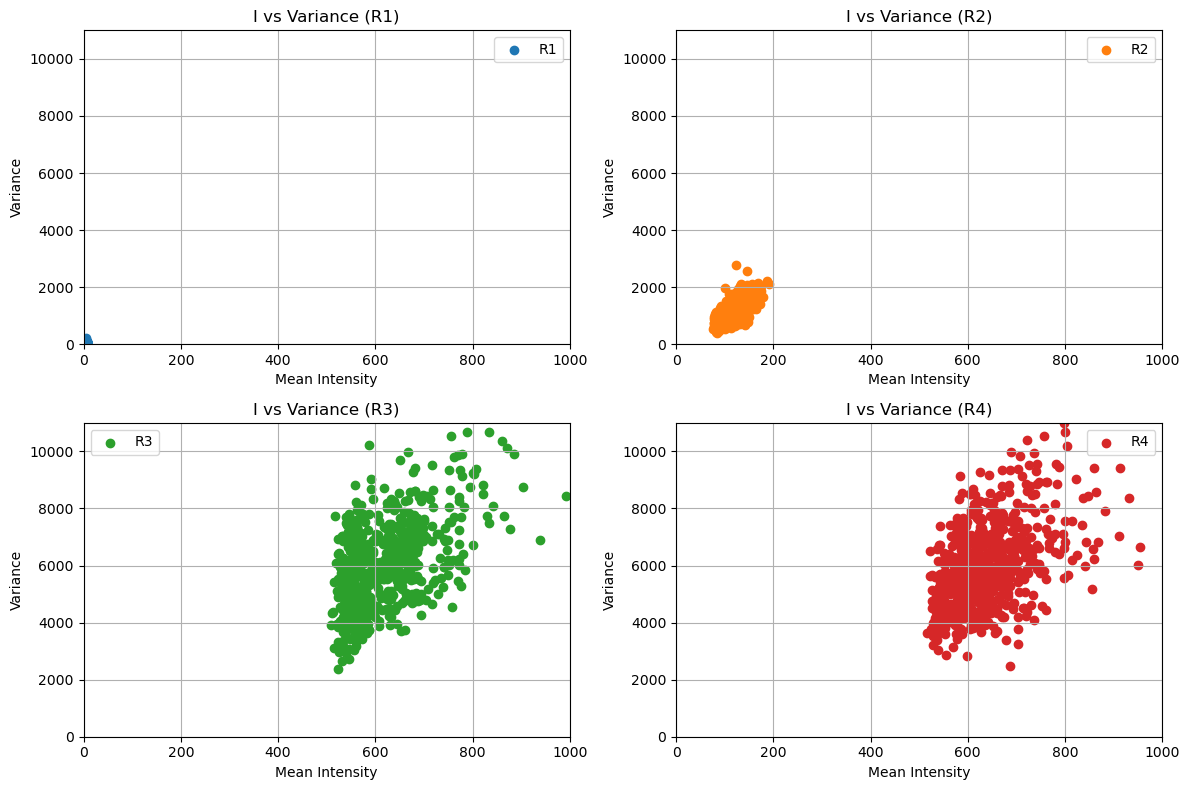

In [14]:
# Perform analysis for R1 to R4 and collect results
results = {}
for region, label in zip([time_series_R1, time_series_R2, time_series_R3, time_series_R4], ['R1', 'R2', 'R3', 'R4']):
    results[label] = non_stationary_noise_analysis(region, time_per_line, 100)




# Extract means and variances for each region
regions = ['R1', 'R2', 'R3', 'R4']
means = [results[region][0] for region in regions]
variances = [results[region][1] for region in regions]

# Set up plots with consistent scaling
plt.figure(figsize=(12, 8))


for i, region in enumerate(regions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(means[i], variances[i], label=region, color=f'C{i}')
    plt.title(f"I vs Variance ({region})")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.legend()
    # Adjust these limits based on the expected range in your data
    plt.xlim(0, 1000)  # Adjust for mean intensity range
    plt.ylim(0, 11000)  # Adjust for variance range


plt.tight_layout()
plt.show()


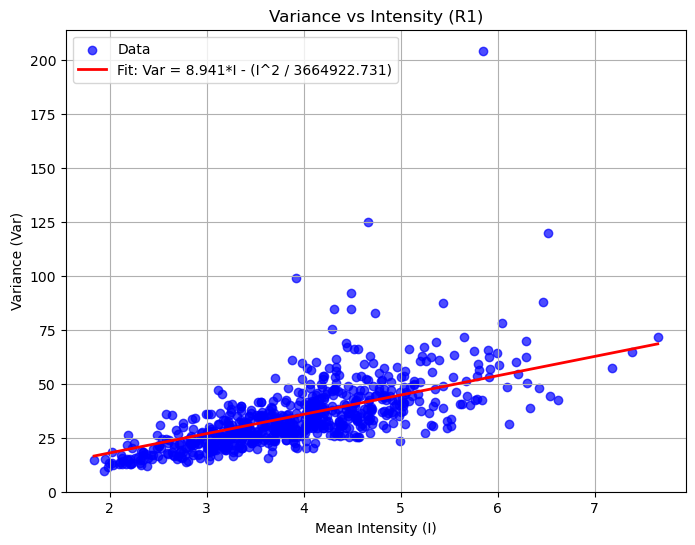

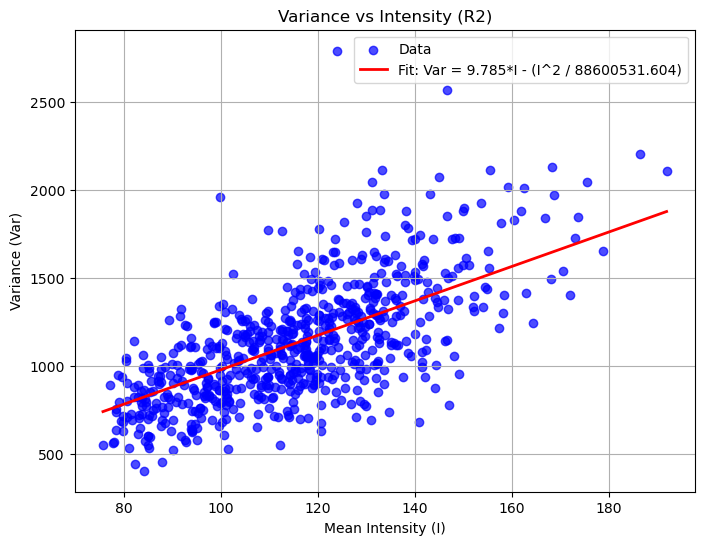

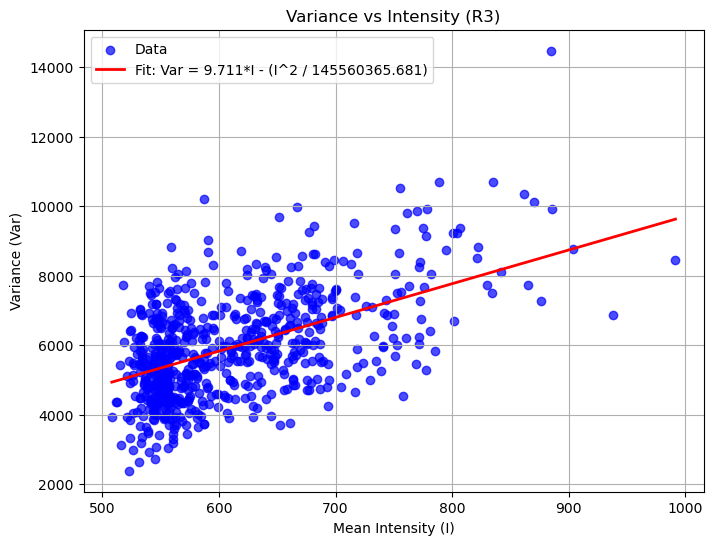

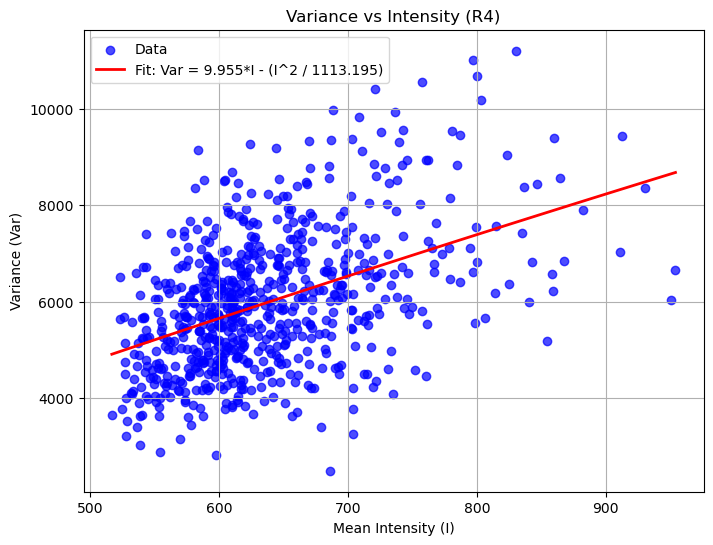

{'R1': {'i': 8.94139795150619,
  'N': 3664922.7305908957,
  'i_std': 0.4961725740574428,
  'N_std': 838369016963.0048},
 'R2': {'i': 9.784598878412389,
  'N': 88600531.60384445,
  'i_std': 0.4646493162812227,
  'N_std': 16577214841255.639},
 'R3': {'i': 9.710500271777981,
  'N': 145560365.68113637,
  'i_std': 0.5439498927914378,
  'N_std': 10381554197650.934},
 'R4': {'i': 9.95458833166883,
  'N': 1113.1949524203599,
  'i_std': 0.601082545025049,
  'N_std': 1128.034905089885}}

In [15]:

def variance_model(I, i, N):
    """
    Model equation for variance: Var = i*I - (I^2 / N).

    Parameters:
        I (array): Mean intensities.
        i (float): Scaling parameter.
        N (float): Parameter related to system noise.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N

def fit_and_plot_variance(I, Var, region_label):
    """
    Fit the variance model to the data and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.

    Returns:
        dict: Fitted parameters {i, N} and their uncertainties.
    """
    # Fit the variance model
    popt, pcov = curve_fit(variance_model, I, Var, p0=[1, 100])
    i, N = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(I), max(I), 100)
    Var_fit = variance_model(I_fit, i, N)

    # Plot the data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(I, Var, label="Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f})", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity ({region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
        # Adjust these limits based on the expected range in your data
    #plt.xlim(0, 1000)  # Adjust for mean intensity range
    #plt.ylim(0, 11000)  # Adjust for variance range
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "i_std": perr[0], "N_std": perr[1]}

# Fit and plot for each region
fit_results = {}
for region, label in zip([results["R1"], results["R2"], results["R3"], results["R4"]], ['R1', 'R2', 'R3', 'R4']):
    I = region[0]  # Mean intensities
    Var = region[1]  # Variances
    fit_results[label] = fit_and_plot_variance(I, Var, label)

# Display the fit results
fit_results


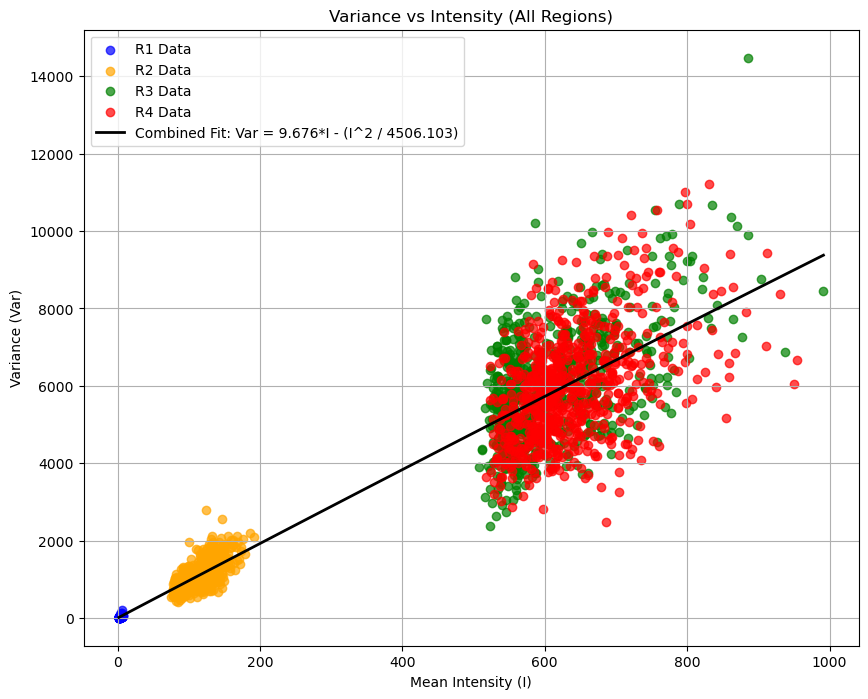

{'i': 9.676166035624489,
 'N': 4506.103163783863,
 'i_std': 0.22358941199877,
 'N_std': 7050.152614753667}

In [16]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

def variance_model(I, i, N):
    """
    Model equation for variance: Var = i*I - (I^2 / N).

    Parameters:
        I (array): Mean intensities.
        i (float): Scaling parameter.
        N (float): Parameter related to system noise.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N

def fit_and_plot_all_regions(results):
    """
    Fit the variance model to all regions' data and plot them together.

    Parameters:
        results (dict): Dictionary containing mean intensities and variances for all regions.

    Returns:
        dict: Fitted parameters {i, N} and their uncertainties for the combined data.
    """
    # Combine all regions' data
    combined_I = []
    combined_Var = []
    for region, data in results.items():
        combined_I.extend(data[0])  # Append mean intensities
        combined_Var.extend(data[1])  # Append variances

    combined_I = np.array(combined_I)
    combined_Var = np.array(combined_Var)

    # Fit the variance model to the combined data
    popt, pcov = curve_fit(variance_model, combined_I, combined_Var, p0=[1, 100])
    i, N = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(combined_I), max(combined_I), 100)
    Var_fit = variance_model(I_fit, i, N)

    # Plot the data for each region and the combined fit
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'green', 'red']
    for (region, data), color in zip(results.items(), colors):
        plt.scatter(data[0], data[1], label=f"{region} Data", alpha=0.7, color=color)

    plt.plot(I_fit, Var_fit, label=f"Combined Fit: Var = {i:.3f}*I - (I^2 / {N:.3f})", color="black", linewidth=2)
    plt.title("Variance vs Intensity (All Regions)")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "i_std": perr[0], "N_std": perr[1]}

# Perform analysis and plot for all regions
fit_results_combined = fit_and_plot_all_regions(results)

# Display the fit results
fit_results_combined


In [17]:
def variance_model_with_background(I, i, N, B):
    """
    Model equation for variance: Var = i*I - (I^2 / N) + B.

    Parameters:
        I (array): Mean intensities.
        i (float): Scaling parameter.
        N (float): Parameter related to system noise.
        B (float): Background signal.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N + B


def bin_data_with_step(I, Var, I_step=1, Var_step=1):
    """
    Bin the data by averaging within specified steps of I and Var.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        tuple: Binned mean intensities and variances.
    """
    # Ensure I and Var are numpy arrays
    I = np.array(I)
    Var = np.array(Var)

    # Create bins based on step sizes
    I_bins = np.floor(I / I_step).astype(int)
    unique_bins = np.unique(I_bins)

    # Calculate binned mean intensities and variances
    binned_I = []
    binned_Var = []
    for b in unique_bins:
        mask = I_bins == b
        if np.any(mask):  # Avoid empty bins
            binned_I.append(np.mean(I[mask]))
            binned_Var.append(np.mean(Var[mask]))

    return np.array(binned_I), np.array(binned_Var)

def fit_and_plot_variance_with_background_binned_step(I, Var, region_label, I_step=1, Var_step=1):
    """
    Bin the data with specified steps, fit the variance model with background signal, and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        dict: Fitted parameters {i, N, B} and their uncertainties.
    """
    # Bin the data with specified steps
    binned_I, binned_Var = bin_data_with_step(I, Var, I_step, Var_step)

    # Fit the variance model with background
    popt, pcov = curve_fit(variance_model_with_background, binned_I, binned_Var, p0=[1, 100, 0])
    i, N, B = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(binned_I), max(binned_I), 100)
    Var_fit = variance_model_with_background(I_fit, i, N, B)

    # Plot the binned data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(binned_I, binned_Var, label="Binned Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f}) + {B:.3f}", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity (Binned with step, {region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "B": B, "i_std": perr[0], "N_std": perr[1], "B_std": perr[2]}


# Subtract background constants from R3 and R4
I_bckg = 400
Var_bckg = 3500
results["R3"] = (np.array(results["R3"][0]) - I_bckg, np.array(results["R3"][1]) - Var_bckg)
results["R4"] = (np.array(results["R4"][0]) - I_bckg, np.array(results["R4"][1]) - Var_bckg)

# Ensure no negative values in the variances
results["R3"] = (results["R3"][0], np.clip(results["R3"][1], 0, None))
results["R4"] = (results["R4"][0], np.clip(results["R4"][1], 0, None))



# Fit and plot for each region with binned data and specified step
fit_results_with_background_binned_step = {}
for region, label in zip([results["R1"], results["R2"], results["R3"], results["R4"]], ['R1', 'R2', 'R3', 'R4']):
    I = region[0]  # Mean intensities
    Var = region[1]  # Variances
    fit_results_with_background_binned_step[label] = fit_and_plot_variance_with_background_binned_step(
        I, Var, label, I_step=10, Var_step=10
    )

# Display the fit results for binned data with steps
fit_results_with_background_binned_step


TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1